In [1]:
library(dplyr)
library(tidyr)
library(Seurat)
library(Matrix)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



In [2]:
tmp1 <- readRDS("mHeart_P10_control.rds")

In [3]:
mHeart.ctrl <- CreateSeuratObject(raw.data=tmp1,min.cells = 10,min.genes = 400)
mHeart.ctrl # 18050 genes across 9400 samples
mHeart.ctrl <- FilterCells(mHeart.ctrl,"nGene",high.thresholds = 4000,low.thresholds = 500)
mHeart.ctrl # 7760 nuclei

An object of class seurat in project SeuratProject 
 18050 genes across 9400 samples.

An object of class seurat in project SeuratProject 
 18050 genes across 7760 samples.

[1] 1952

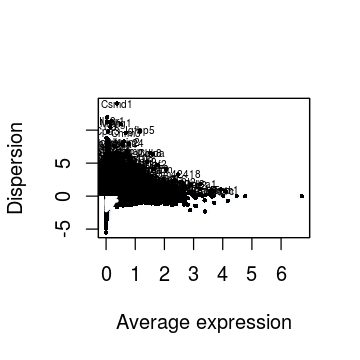

In [4]:
options(repr.plot.width=3,repr.plot.height=3)
mHeart.ctrl <- NormalizeData(mHeart.ctrl)
mHeart.ctrl <- FindVariableGenes(object = mHeart.ctrl,x.low.cutoff = 0.05,y.cutoff = 0.7)
length(mHeart.ctrl@var.genes) # 1952 genes

In [5]:
# exclude un-relevant genes for clustering
ctrl.gene.list <- mHeart.ctrl@var.genes
ctrl.rp.genes <- grep("^Rp",rownames(mHeart.ctrl@data),value=T,ignore.case = T)
ctrl.gene.list2 <- setdiff(ctrl.gene.list,ctrl.rp.genes) # 1940 (ctrl 12 rp genes)
####[Here there is a version update of seurat, the default differentially expression test method was changed, this why the result may be different]
### To fully reproduce the results we have, you can directly run "mHeart.ctrl <- readRDS("mHeart_P10_control_seurat.rds") in the R"
ctrl.batch.genes <- FindAllMarkers(mHeart.ctrl,logfc.threshold = .5,only.pos = T) # 7 genes 
ctrl.gene.list3 <- setdiff(ctrl.gene.list2,ctrl.batch.genes$gene)  # 1925 genes (14 genes)

In [6]:
load("cellCycleGenes.Rdata")

In [7]:
## regress out cell cycle related genes
mHeart.ctrl <- CellCycleScoring(object = mHeart.ctrl, s.genes = s.genes, g2m.genes = g2m.genes, set.ident = TRUE)

In [8]:
table(mHeart.ctrl@meta.data$orig.ident)


Pei1-run1n2 Pei2-run1n2   WT-run1n2 
       3334        3047        1379 

In [9]:
# fill in the batch effect in the @meta.data
mHeart.ctrl@meta.data$batch <- 1
mHeart.ctrl@meta.data[mHeart.ctrl@meta.data$orig.ident %in% c("Pei1-run1n2","Pei2-run1n2"),]$batch <- 2

In [10]:
mHeart.ctrl <- ScaleData(mHeart.ctrl,vars.to.regress = c("nUMI","batch","S.Score","G2M.Score"),genes.use = ctrl.gene.list3)
mHeart.ctrl <- RunPCA(mHeart.ctrl,pc.genes = ctrl.gene.list3,pcs.compute=40, do.print = TRUE, pcs.print = 1:5, genes.print = 5)
mHeart.ctrl <- ProjectPCA(mHeart.ctrl)

Regressing out: nUMI, batch, S.Score, G2M.Score



Time Elapsed:  21.7694382667542 secs

Scaling data matrix


[1] "PC1"
[1] "Dcn"    "Col3a1" "Col1a2" "Gpc6"   "Ebf1"  
[1] ""
[1] "Cacna1c" "Dmd"     "Cacnb2"  "Kcnd2"   "Kcnn2"  
[1] ""
[1] ""
[1] "PC2"
[1] "Abca8a" "Pcdh9"  "Tenm3"  "Pcsk6"  "Col3a1"
[1] ""
[1] "Pecam1" "Emcn"   "Egfl7"  "Flt1"   "Ptprb" 
[1] ""
[1] ""
[1] "PC3"
[1] "Mb"     "Actc1"  "Atp5g3" "Ndufa4" "Tpm1"  
[1] ""
[1] "Dmd"     "Cacna1c" "Prkg1"   "Cacnb2"  "Pde7b"  
[1] ""
[1] ""
[1] "PC4"
[1] "Ablim3"    "Ifi203-ps" "Nav3"      "Btnl9"     "Dach1"    
[1] ""
[1] "Tmem108" "Npr3"    "Vwf"     "Cdh11"   "Chrm3"  
[1] ""
[1] ""
[1] "PC5"
[1] "Ablim3" "Cyyr1"  "Etl4"   "Nav3"   "Meox2" 
[1] ""
[1] "F13a1"  "Mrc1"   "Slc9a9" "Myo1f"  "Adgre1"
[1] ""
[1] ""
[1] "PC1"
 [1] "Dcn"     "Col3a1"  "Col1a2"  "Gpc6"    "Ebf1"    "Col1a1"  "Fbn1"   
 [8] "Fbxl7"   "Abca8a"  "Lum"     "Mfap5"   "Sulf1"   "Igfbp7"  "Pcsk6"  
[15] "Pcdh9"   "Aspn"    "Kcnt2"   "Col5a2"  "C1qtnf7" "Gsn"     "Tenm3"  
[22] "Dpt"     "Col14a1" "Col15a1" "Adamts5" "Bicc1"   "Col6a2"  "Fndc1"  
[29] "Ltbp4"   

In [11]:
cluster_pc_res <- function(pancreas,pcs=1:25,res=0.6) {
  pancreas<- FindClusters(object = pancreas, reduction.type = "pca", dims.use = pcs, resolution = res, print.output = 0, save.SNN = TRUE)
  pancreas <- RunTSNE(object = pancreas, dims.use = pcs, do.fast = TRUE)
}

In [12]:
mHeart.ctrl <- cluster_pc_res(mHeart.ctrl,pcs=1:20,res=c(0.6,1,1.2,1.4,1.6,2))

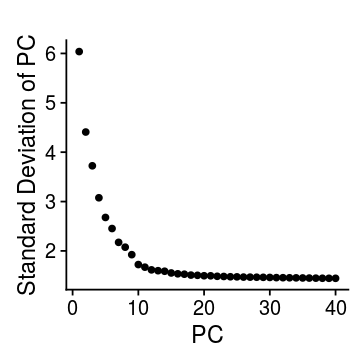

In [13]:
options(repr.plot.width=3,repr.plot.height=3)
PCElbowPlot(object =mHeart.ctrl,num.pc = 40)

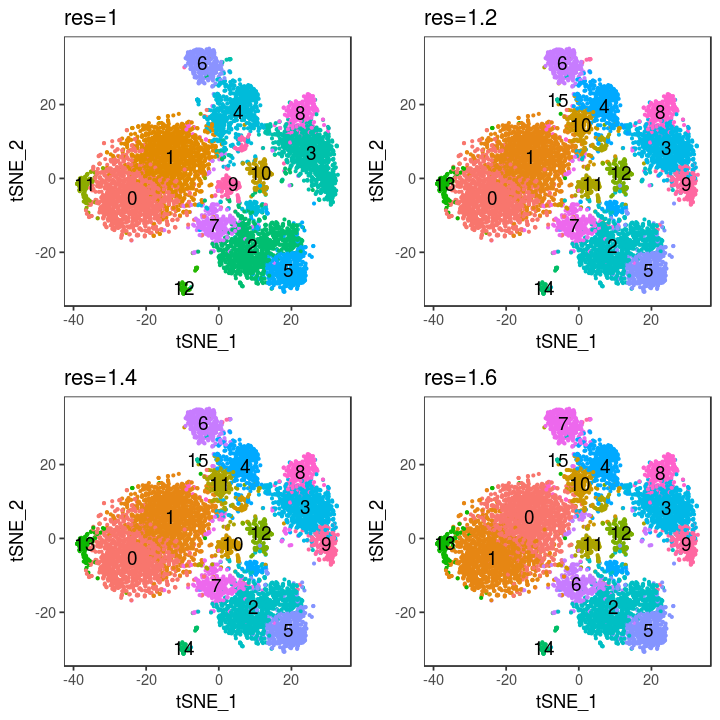

In [14]:
options(repr.plot.width=6,repr.plot.height=6)
p1 <- TSNEPlot(object = mHeart.ctrl , pt.size = 0.5,do.label = T, no.legend=T, do.return = T,group.by="res.1") + ggtitle("res=1")
p2 <- TSNEPlot(object = mHeart.ctrl , pt.size = 0.5,do.label = T, no.legend=T, do.return = T,group.by="res.1.2")+ ggtitle("res=1.2")
p3 <- TSNEPlot(object = mHeart.ctrl , pt.size = 0.5,do.label = T, no.legend=T, do.return = T,group.by="res.1.4")+ ggtitle("res=1.4")
p4 <- TSNEPlot(object = mHeart.ctrl , pt.size = 0.5,do.label = T, no.legend=T, do.return = T,group.by="res.1.6")+ ggtitle("res=1.6")
plot_grid(p1,p2,p3,p4,nrow = 2)

In [15]:
mHeart.ctrl <- SetAllIdent(mHeart.ctrl,id="res.1.2")

In [16]:
mHeart.ctrl@meta.data$res.label <- plyr::mapvalues(mHeart.ctrl@meta.data$res.1.2,
                                                   c(3,9,8,13,7,0,1,15,2,5,14,12,6,4,10,11),
                                                   c("mCM1","mCM1","mCM2","pCM","dCM1","dCM2","dCM3","LEC","Fib1",
                                                     "Fib2","Epi", "BC","EC1","EC2","EC2","Per/SMC"))
mHeart.ctrl <- SetAllIdent(mHeart.ctrl,id="res.label")

In [ ]:
#mHeart.ctrl.mak <- FindAllMarkers(mHeart.ctrl,only.pos = T,logfc.threshold = .5) # this will take a little bit time to finish
# check the representative markers for each clusters
#mHeart.ctrl.mak %>% group_by(cluster) %>% slice(1:5)

In [23]:
mHeart.ctrl.col <- c("#A58AFF", "#00B6EB", "#00C094", "#E38900",
"#F8766D","#06A4FF", "#53B400","#00BC56",
"#FB61D7", "#FF66A8", "#C49A00",
"#00BFC4", "#FB61D7", "gray60")

In [28]:
mHeart.ctrl@ident <- factor(mHeart.ctrl@ident,
                            levels=c("mCM1","mCM2","pCM","dCM1","dCM2","dCM3","LEC","Fib1","Fib2","Epi", "BC",
                                     "EC1","EC2","Per/SMC"))

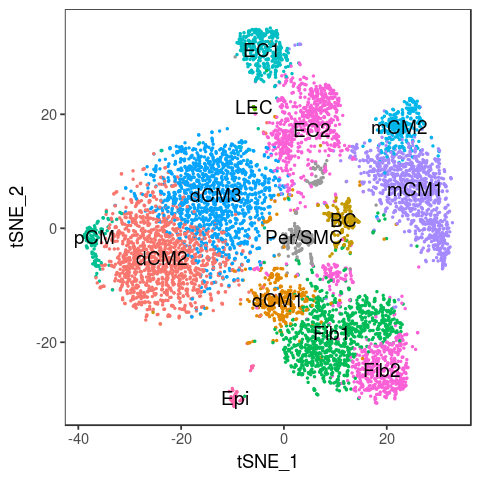

In [29]:
options(repr.plot.width=4,repr.plot.height=4)
TSNEPlot(object = mHeart.ctrl , pt.size = 0.3,do.label = T, no.legend=T, do.return = T) + 
 scale_colour_manual(values=mHeart.ctrl.col)

In [25]:
fig1c.genes <- c("Pln","Actc1","Tnnc1","Atp5b","Ndufa4","Cox5a",
                  "Gata4","Myocd","Mhrt","Postn","Fbn1","Col5a1",
                  "Wt1","Upk3b","Muc16","Mrc1","Fyb","Cd86",
                  "Pecam1","Flt1","Tie1","Pdgfrb","Notch3","Cspg4")

In [26]:
library("reshape2")
plot_vln<-function(t,my.genes3) {
  d <- as.matrix(t@data[intersect(my.genes3,rownames(t@data)),])
  dd <- melt(d,id=row.names)
  dd <- dd %>% dplyr::rename(gene=Var1,cell=Var2)
  dd$tree.ident <- t@ident[dd$cell]
  str(dd$tree.ident)
  dd$gene <- factor(dd$gene,levels=intersect(my.genes3,rownames(t@data)))
  ggplot(dd,aes(tree.ident,value,fill=tree.ident))+geom_violin(scale="width",trim=T,alpha=0.8,adjust=1)+facet_wrap(~gene,scales="free_y",ncol=1,strip.position = "right") + theme(strip.background = element_blank(), strip.placement = "outside",axis.text.y=element_blank(),axis.title.y=element_blank(),strip.text.y = element_text(colour = "red", angle = 360,size=10),legend.position="none",panel.grid=element_blank(), panel.border=element_blank())+theme(axis.text.x = element_text(angle = 45,hjust=1,vjust=1,size=rel(0.9)),legend.position="none") + xlab("")
}


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



 Factor w/ 14 levels "mCM1","mCM2",..: 1 1 1 1 1 1 1 1 1 1 ...


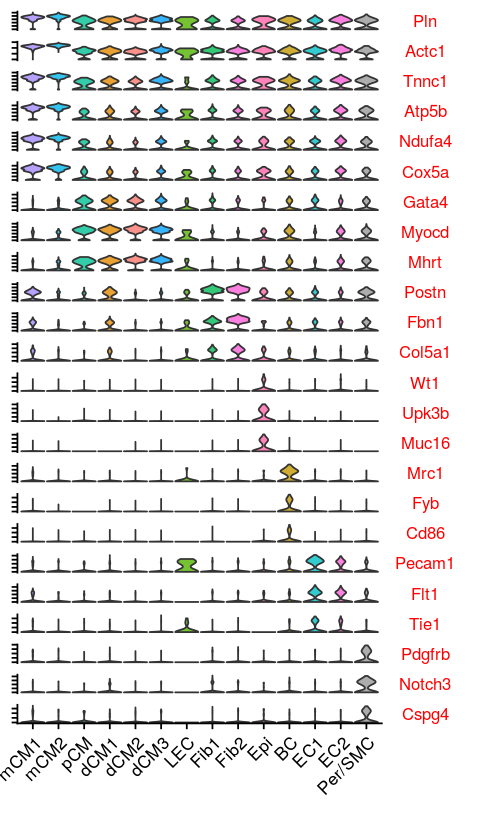

In [31]:
options(repr.plot.width=4,repr.plot.height=7)
plot_vln(mHeart.ctrl,fig1c.genes) + scale_fill_manual(values=mHeart.ctrl.col)

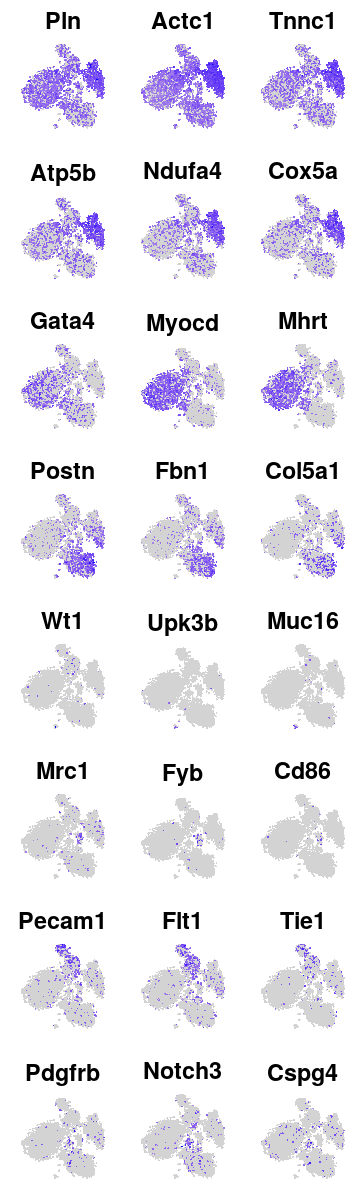

In [33]:
options(repr.plot.width=3,repr.plot.height=10)
FeaturePlot(mHeart.ctrl,fig1c.genes,cols.use = c("lightgrey","blue"),pt.size=.2,no.axes = T,nCol = 3)